In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='ticks', context='talk')
%matplotlib inline

In [292]:
june=pd.read_csv("C:\\Users\\jpisel\\Downloads\\pickups\\june 2016.csv", index_col=[0], parse_dates=[0], header=None)
july=pd.read_csv("C:\\Users\\jpisel\\Downloads\\pickups\\july 2016.csv", index_col=[0], parse_dates=[0], header=None)
august=pd.read_csv("C:\\Users\\jpisel\\Downloads\\pickups\\august 2016.csv", index_col=[0], parse_dates=[0], header=None)
sept=pd.read_csv("C:\\Users\\jpisel\\Downloads\\pickups\\september 2016.csv", index_col=[0], parse_dates=[0], header=None)
octo=pd.read_csv("C:\\Users\\jpisel\\Downloads\\pickups\\october 2016.csv", index_col=[0], parse_dates=[0], header=None)
nov=pd.read_csv("C:\\Users\\jpisel\\Downloads\\pickups\\november 2016.csv", index_col=[0], parse_dates=[0], header=None)
dec=pd.read_csv("C:\\Users\\jpisel\\Downloads\\pickups\\december 2016.csv", index_col=[0], parse_dates=[0], header=None)


data=pd.concat([june,july, august, sept, octo, nov, dec])

In [293]:
data.head()

,1
0,
2016-06-13 14:03:53,Uber
2016-06-13 14:07:20,Uber
2016-06-13 14:11:35,Uber
2016-06-13 14:12:35,Uber
2016-06-13 14:12:55,Uber


In [294]:
data.columns=['company']
data['counts']=1

In [295]:
new=data.resample('d').sum()
new.head()

,counts
0,
2016-06-13,101
2016-06-14,134
2016-06-15,133
2016-06-16,140
2016-06-17,177


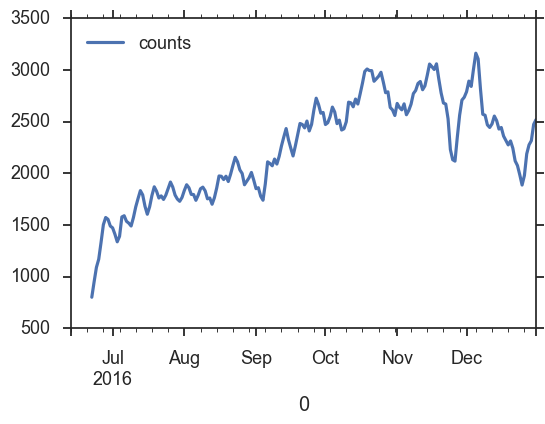

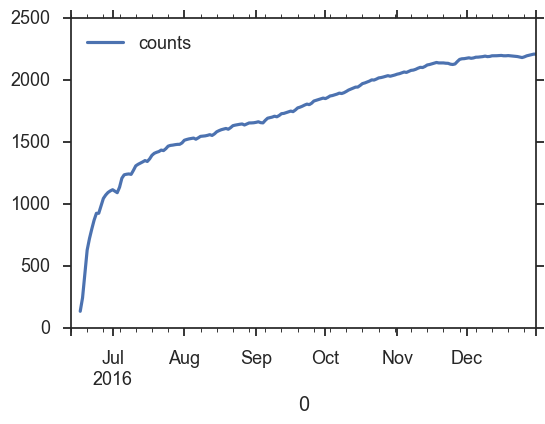

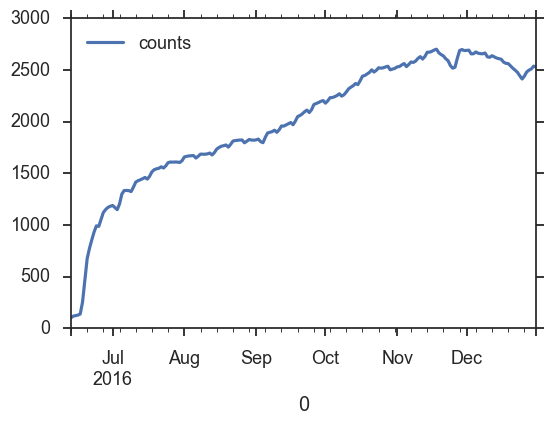

In [296]:
new.rolling(10).mean().plot(label='rolling')
new.expanding(5).mean().plot(label='expanding')
new.ewm(alpha=0.03).mean().plot(label='emwa')

In [297]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

In [298]:
mod = sm.tsa.statespace.SARIMAX(new, trend='c', order=(1,1,1))

In [299]:
def tsplot(y, lags=None, figsize=(10, 8)):
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(1.5) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

(<matplotlib.axes._subplots.AxesSubplot at 0x3224d3c8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x32b4ca20>)

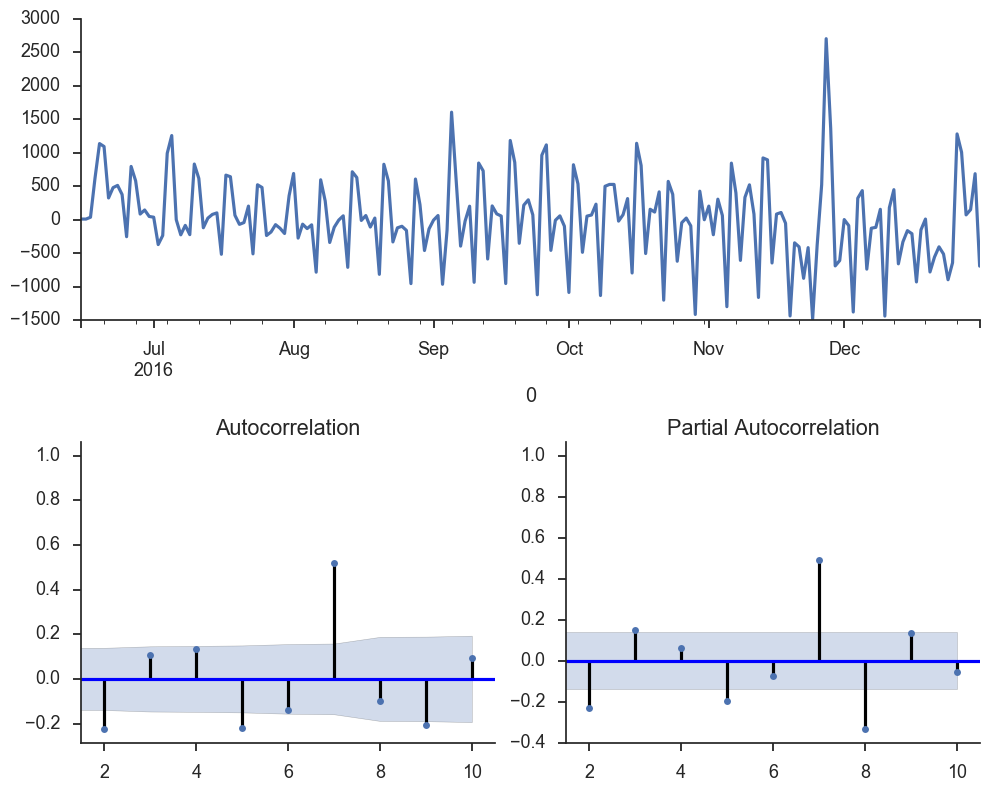

In [300]:
res = mod.fit()
tsplot(res.resid[2:], lags=10)

In [301]:
mod_seasonal = sm.tsa.statespace.SARIMAX(new, trend='c',
                           order=(1, 0, 1), seasonal_order=(0, 1, 0, 7))
res_seasonal = mod_seasonal.fit()

(<matplotlib.axes._subplots.AxesSubplot at 0x34b5d668>,
 <matplotlib.axes._subplots.AxesSubplot at 0x34e1cb00>)

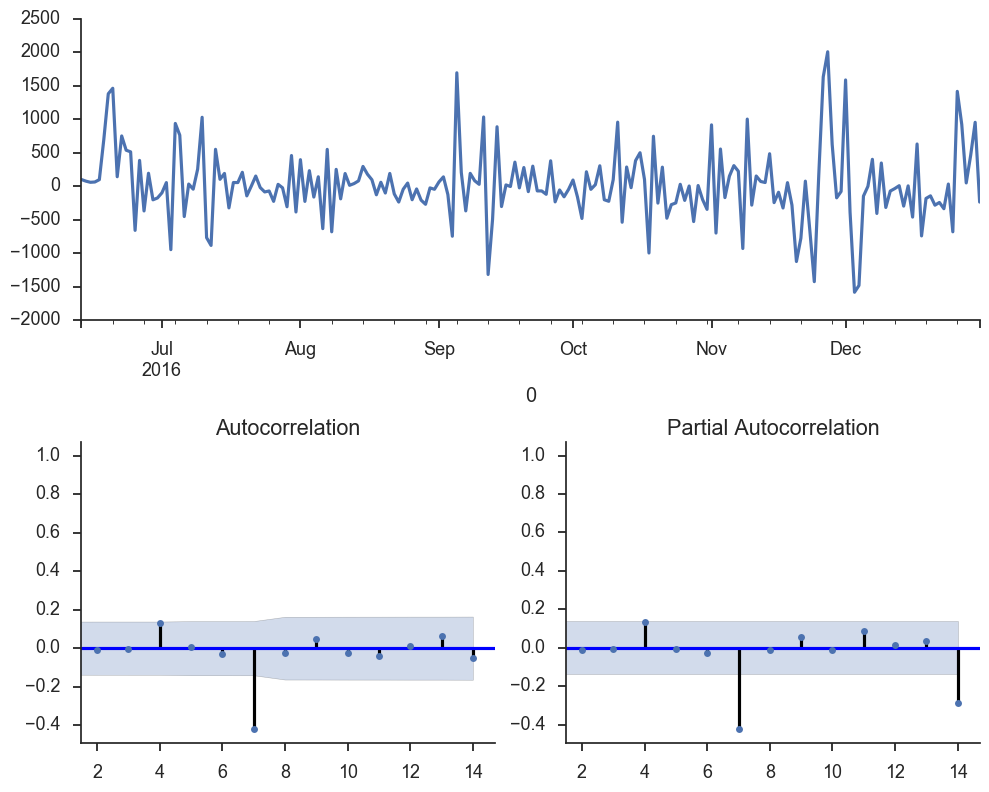

In [302]:
tsplot(res_seasonal.resid[0:], lags=14)


In [307]:
pred = res_seasonal.get_prediction(start='2016-11-01')
pred_ci = pred.conf_int()

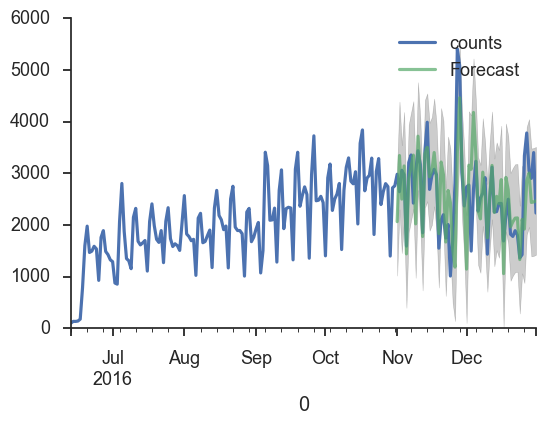

In [308]:
ax = new.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.legend()
sns.despine()

In [313]:
pred_dy = res_seasonal.get_prediction(start='2016-07-01', dynamic='2016-12-15')
pred_dy_ci = pred_dy.conf_int()

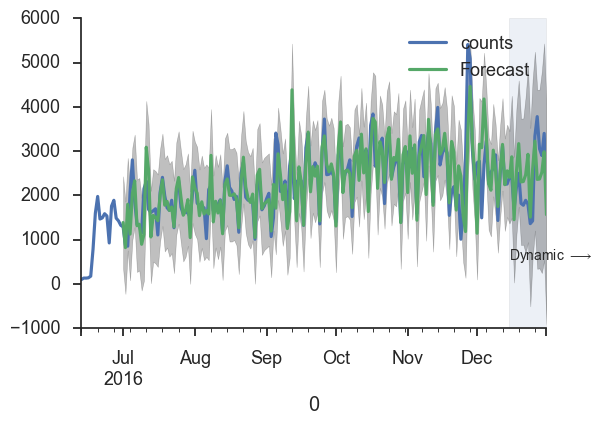

In [315]:
ax = new.plot(label='observed')
pred_dy.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_dy_ci.index,
                pred_dy_ci.iloc[:, 0],
                pred_dy_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.Timestamp('2016-12-15'), new.index[-1],
                 alpha=.1, zorder=-1)
ax.annotate('Dynamic $\\longrightarrow$', (pd.Timestamp('2016-12-15'), 550))

plt.legend()
sns.despine()